In [ ]:
!pip install Pillow

# Clone the Github Repository

In [ ]:
%cd /content
!git clone https://github.com/kutayozdur/Face-Mask-Detection.git
%cd /content/Face-Mask-Detection/

/content
Cloning into 'Face-Mask-Detection'...
/content/Face-Mask-Detection


# Loading the dataset from Kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

print("Path to dataset files:", path)

100%|██████████| 398M/398M [00:03<00:00, 126MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1


In [ ]:
import shutil
import os

# Path to the downloaded dataset
source_path = path  # Use the path returned by kagglehub

# Path of GitHub repository folder
repo_path = "/content/Face-Mask-Detection"

# Move the dataset
shutil.move(source_path, os.path.join(repo_path, "dataset"))

print("Dataset moved to:", os.path.join(repo_path, "dataset"))


Dataset moved to: /content/Face-Mask-Detection/dataset


# Exploring the dataset

In [ ]:
import os

dataset_path = "/content/Face-Mask-Detection/dataset"
print(os.listdir(dataset_path))

['annotations', 'images']


In [ ]:
images_dir = os.path.join(dataset_path, "images")

images_list = os.listdir(images_dir)
print(f"Number of images: {len(images_list)}")

# Maybe print the first 5 to see what filenames look like
print("Sample image filenames:", images_list[:5])

Number of images: 853
Sample image filenames: ['maksssksksss656.png', 'maksssksksss850.png', 'maksssksksss756.png', 'maksssksksss682.png', 'maksssksksss801.png']


In [ ]:
annotations_dir = os.path.join(dataset_path, "annotations")
annotations_list = os.listdir(annotations_dir)
print(f"Number of annotations: {len(annotations_list)}")

# Check out a few annotation file names
print("Sample annotation filenames:", annotations_list[:5])

Number of annotations: 853
Sample annotation filenames: ['maksssksksss98.xml', 'maksssksksss720.xml', 'maksssksksss530.xml', 'maksssksksss851.xml', 'maksssksksss631.xml']


In [ ]:
import xml.etree.ElementTree as ET

# Pick one annotation file
sample_annotation = annotations_list[0]
annotation_path = os.path.join(annotations_dir, sample_annotation)

# Parse the XML
tree = ET.parse(annotation_path)
root = tree.getroot()

print(f"Annotation file: {sample_annotation}")
for child in root:
    print(child.tag, child.text)

Annotation file: maksssksksss98.xml
folder images
filename maksssksksss98.png
size 
        
segmented 0
object 
        
object 
        
object 
        
object 
        


In [ ]:
from collections import Counter

labels_count = Counter()

for xml_file in annotations_list:
    xml_path = os.path.join(annotations_dir, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Each <object> contains a <name> for the class
    for obj in root.findall("object"):
        class_name = obj.find("name").text
        labels_count[class_name] += 1

print("Count of each label:", labels_count)

Count of each label: Counter({'with_mask': 3232, 'without_mask': 717, 'mask_weared_incorrect': 123})


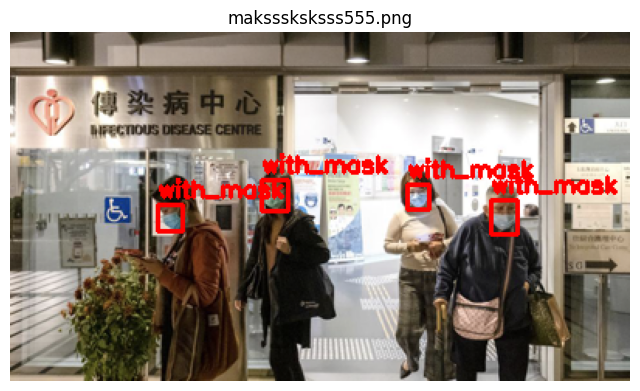

In [ ]:
import random
import cv2
import matplotlib.pyplot as plt

# Pick a random annotation
random_anno = random.choice(annotations_list)
random_anno_path = os.path.join(annotations_dir, random_anno)

# Parse the annotation to get bounding boxes
tree = ET.parse(random_anno_path)
root = tree.getroot()
filename = root.find("filename").text
img_path = os.path.join(images_dir, filename)

# Load the image
img = cv2.imread(img_path)
if img is None:
    print(f"Could not load image: {img_path}")
else:
    # Convert from BGR to RGB for plotting
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw the bounding boxes
    for obj in root.findall("object"):
        class_name = obj.find("name").text
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        # Draw rectangle
        cv2.rectangle(img_rgb, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(img_rgb, class_name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Show the image
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.title(filename)
    plt.axis('off')
    plt.show()

# Preprocessing the data for SSD training

In [ ]:
import os
import xml.etree.ElementTree as ET

def parse_annotation(xml_file):
    """
    Parses an XML annotation file and extracts bounding boxes and class names.

    Parameters:
    - xml_file (str): Path to the XML annotation file.

    Returns:
    - dict: Contains the image filename and a list of objects with class names and bounding boxes.
    """
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Extract filename and normalize it
        filename = root.find("filename").text.strip()

        objects = []
        for obj in root.findall("object"):
            class_name = obj.find("name").text
            bndbox = obj.find("bndbox")

            # Convert bbox from dict to list format
            bbox = [
                int(bndbox.find("xmin").text),
                int(bndbox.find("ymin").text),
                int(bndbox.find("xmax").text),
                int(bndbox.find("ymax").text),
            ]
            objects.append({"class_name": class_name, "bbox": bbox})

        return {"filename": filename, "objects": objects}

    except Exception as e:
        print(f"Error parsing file {xml_file}: {e}")
        return {"filename": None, "objects": []}

# Test parsing one file
sample_parsed = parse_annotation(os.path.join(annotations_dir, annotations_list[0]))
print(sample_parsed)

{'filename': 'maksssksksss98.png', 'objects': [{'class_name': 'with_mask', 'bbox': [196, 43, 236, 91]}, {'class_name': 'with_mask', 'bbox': [41, 73, 65, 95]}, {'class_name': 'with_mask', 'bbox': [263, 62, 287, 85]}, {'class_name': 'with_mask', 'bbox': [344, 80, 377, 106]}]}


In [ ]:
class_map = {"with_mask": 1, "without_mask": 2, "mask_weared_incorrect": 3}

# Function to map class names to IDs
def map_class_name_to_id(class_name):
    return class_map[class_name]

In [ ]:
import random
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

def preprocess_image(image_path, target_size=(320, 320), augment=False):
    """
    Preprocesses an image by resizing, normalizing, and augmenting, returning a NumPy array.

    Parameters:
    - image_path (str): Path to the image file.
    - target_size (tuple): Target size for resizing (width, height).
    - augment (bool): Whether to apply augmentation.

    Returns:
    - numpy.ndarray: Preprocessed image in NumPy array format.
    """
    transform_list = []

    # Optional augmentation: Horizontal Flip
    if augment:
      transform_list.append(transforms.RandomHorizontalFlip(p=0.5))

    # Resize and normalize
    transform_list.extend([
        transforms.Resize(target_size),
        transforms.ToTensor()  # Converts to tensor and scales to [0, 1]
    ])

    transform_pipeline = transforms.Compose(transform_list)
    image = Image.open(image_path).convert("RGB")
    transformed_image = transform_pipeline(image)

    # Convert tensor to NumPy array (HWC order)
    numpy_image = transformed_image.permute(1, 2, 0).numpy()

    return numpy_image

In [ ]:
import os
import cv2
import numpy as np

# Define the paths
images_dir = "/content/Face-Mask-Detection/dataset/images"  # Update with your image folder

# List the first 5 images
image_filenames = os.listdir(images_dir)[:5]

# Process each image
for image_filename in image_filenames:
    image_path = os.path.join(images_dir, image_filename)
    preprocessed_image = preprocess_image(image_path)

    # Print details of the preprocessed image
    print(f"Image: {image_filename}")
    print(f"Shape: {preprocessed_image.shape}")
    print(f"Data Type: {preprocessed_image.dtype}")
    print(f"Min Pixel Value: {np.min(preprocessed_image):.4f}")
    print(f"Max Pixel Value: {np.max(preprocessed_image):.4f}")
    print("-" * 50)

Image: maksssksksss656.png
Shape: (320, 320, 3)
Data Type: float32
Min Pixel Value: 0.0000
Max Pixel Value: 1.0000
--------------------------------------------------
Image: maksssksksss850.png
Shape: (320, 320, 3)
Data Type: float32
Min Pixel Value: 0.0157
Max Pixel Value: 0.9529
--------------------------------------------------
Image: maksssksksss756.png
Shape: (320, 320, 3)
Data Type: float32
Min Pixel Value: 0.0000
Max Pixel Value: 1.0000
--------------------------------------------------
Image: maksssksksss682.png
Shape: (320, 320, 3)
Data Type: float32
Min Pixel Value: 0.0000
Max Pixel Value: 1.0000
--------------------------------------------------
Image: maksssksksss801.png
Shape: (320, 320, 3)
Data Type: float32
Min Pixel Value: 0.0000
Max Pixel Value: 1.0000
--------------------------------------------------


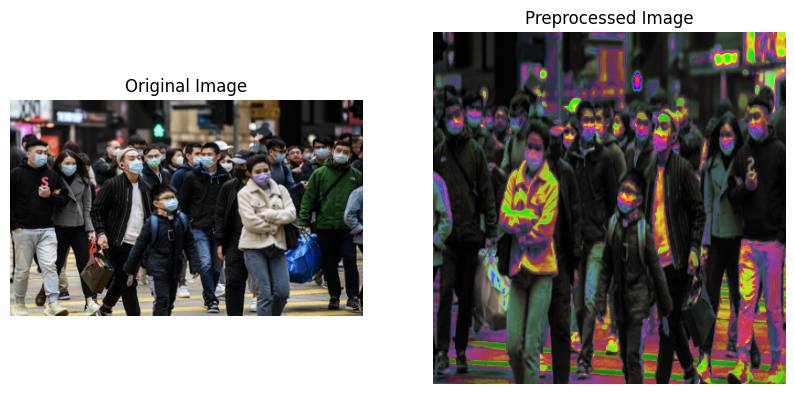

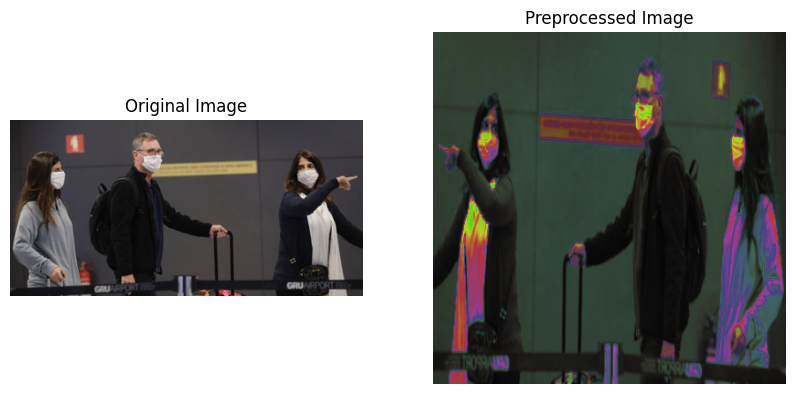

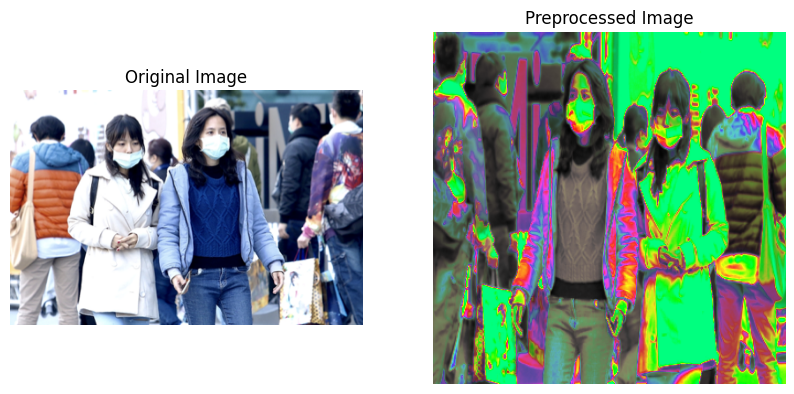

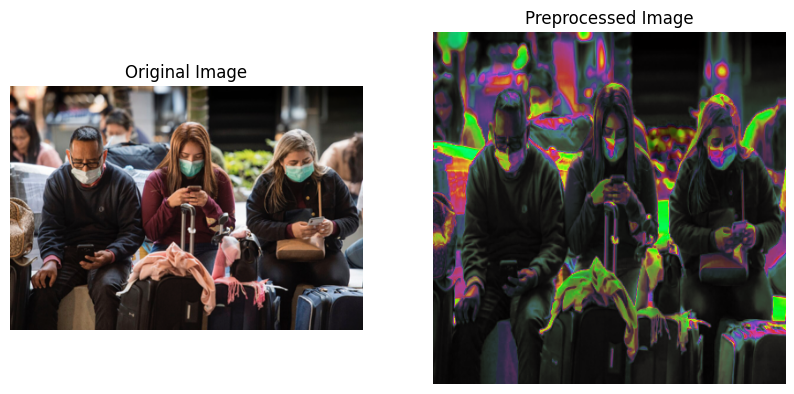

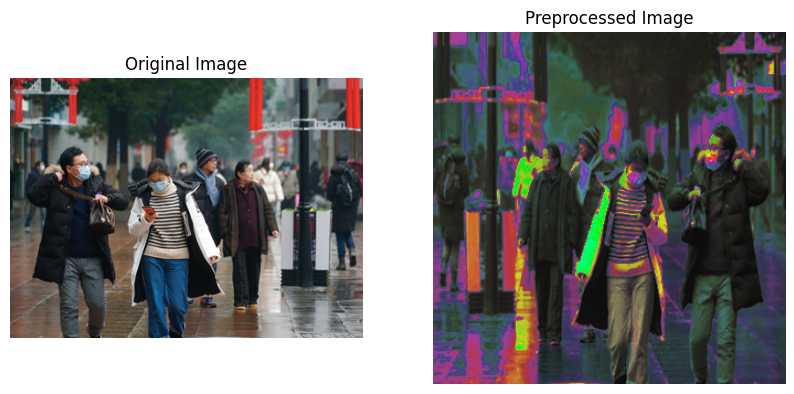

In [ ]:
import matplotlib.pyplot as plt

# Process and display a few images
for image_filename in image_filenames:
    image_path = os.path.join(images_dir, image_filename)
    preprocessed_image = preprocess_image(image_path, augment=True)

    # Display the original and preprocessed image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert for display
    preprocessed_image_rgb = cv2.cvtColor((preprocessed_image * 255).astype("uint8"), cv2.COLOR_HSV2RGB)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed_image_rgb)
    plt.title("Preprocessed Image")
    plt.axis("off")

    plt.show()

In [ ]:
def prepare_dataset(images_dir, annotations_dir):
    """
    Prepares the dataset by loading images, converting bounding boxes to the correct format,
    and mapping class names to numerical IDs.
    """
    dataset = []

    for xml_file in os.listdir(annotations_dir):
        annotation_path = os.path.join(annotations_dir, xml_file)
        parsed_data = parse_annotation(annotation_path)  # Parse the XML file

        # Get full image path
        image_path = os.path.join(images_dir, parsed_data["filename"])

        # Preprocess the image
        image = preprocess_image(image_path, augment=True)

        # Prepare labels and bounding boxes
        labels = []
        bboxes = []
        for obj in parsed_data["objects"]:
            labels.append(map_class_name_to_id(obj["class_name"]))

            # Append bbox directly (already in list format)
            bboxes.append(obj["bbox"])

        # Append the sample to the dataset
        dataset.append({"image": image, "labels": labels, "bboxes": bboxes})

    return dataset

In [ ]:
images_dir = "/content/Face-Mask-Detection/dataset/images"
annotations_dir = "/content/Face-Mask-Detection/dataset/annotations"

# Call the function to build the dataset list
dataset = prepare_dataset(images_dir, annotations_dir)

In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_test_data = train_test_split(dataset, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=42)

print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")

Train: 682, Validation: 85, Test: 86


In [ ]:
def data_generator(data, batch_size):
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        images = np.array([item["image"] for item in batch])
        labels = [item["labels"] for item in batch]
        bboxes = [item["bboxes"] for item in batch]
        yield images, labels, bboxes

# Training SSD-MobileNet

In [ ]:
import torchvision
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.models.detection.anchor_utils import AnchorGenerator

# Load pre-trained SSD-MobileNet model
model = ssdlite320_mobilenet_v3_large(pretrained=True)

# Replace the classification head to match your dataset (3 classes + 1 background class)
num_classes = 3 + 1  # Add 1 for the background
model.head.classification_head.num_classes = num_classes

model = model.to("cuda")

print(model)

SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

In [ ]:
# SSD comes with a built-in loss calculation
from torch.optim import Adam
import torch.optim as optim

# Define the optimizer with weight decay
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Optionally define your custom loss function (if needed)
def ssd_loss(predictions, targets):
    classification_loss = ...  # Cross-entropy
    localization_loss = ...  # Smooth L1 loss
    return classification_loss + localization_loss

In [ ]:
import torch

def custom_collate_fn(batch):
    """
    Custom collate function for handling variable-sized labels and bounding boxes in object detection datasets.

    Args:
        batch (list): A list of dataset samples, where each sample is a dictionary with keys:
                      - "image": Preprocessed image (numpy array).
                      - "labels": List of labels.
                      - "bboxes": List of bounding boxes.

    Returns:
        tuple: A tuple containing:
               - images: Tensor of batched images.
               - targets: List of dictionaries with keys "boxes" and "labels".
    """
    images = []
    targets = []

    for sample in batch:
        # Convert numpy image to PyTorch tensor
        images.append(torch.from_numpy(sample["image"]).permute(2, 0, 1))  # Convert HWC to CHW

        # Prepare labels and bounding boxes
        targets.append({
            "boxes": torch.tensor(sample["bboxes"], dtype=torch.float32),
            "labels": torch.tensor(sample["labels"], dtype=torch.int64)
        })

    return torch.stack(images, dim=0), targets

In [ ]:
from torch.utils.data import DataLoader
import torch

# Create DataLoader
batch_size = 32
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate_fn
)

val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn
)

# Training loop with early stopping
num_epochs = 80
train_losses = []
val_losses = []
patience = 5  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0

    for images, targets in train_loader:
        # Convert images to float32 and move to GPU
        images = [img.to("cuda", dtype=torch.float32) for img in images]

        # Move targets (boxes and labels) to GPU
        targets = [
            {
                "boxes": target["boxes"].to("cuda", dtype=torch.float32),
                "labels": target["labels"].to("cuda", dtype=torch.int64)
            }
            for target in targets
        ]

        # Forward pass
        loss_dict = model(images, targets)

        # Sum all loss components
        losses = sum(loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.train()  # Temporarily set model to training mode to compute loss
    val_loss = 0

    with torch.no_grad():  # Disable gradient computation
        for images, targets in val_loader:
            # Convert images to float32 and move to GPU
            images = [img.to("cuda", dtype=torch.float32) for img in images]

            # Move targets (boxes and labels) to GPU
            targets = [
                {
                    "boxes": target["boxes"].to("cuda", dtype=torch.float32),
                    "labels": target["labels"].to("cuda", dtype=torch.int64)
                }
                for target in targets
            ]

            # Forward pass to compute loss
            loss_dict = model(images, targets)  # Should now return a loss dictionary

            # Sum all loss components
            total_loss = sum(loss_dict.values())
            val_loss += total_loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early Stopping Logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0  # Reset the counter if validation loss improves
    else:
        early_stop_counter += 1
        print(f"Validation loss did not improve for {early_stop_counter} epochs.")
        if early_stop_counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break

Epoch [1/80] - Train Loss: 10.4799, Val Loss: 7.5308
Epoch [2/80] - Train Loss: 7.2621, Val Loss: 6.4979
Epoch [3/80] - Train Loss: 6.3317, Val Loss: 6.0572
Epoch [4/80] - Train Loss: 5.8893, Val Loss: 5.8612
Epoch [5/80] - Train Loss: 5.5821, Val Loss: 5.7183
Epoch [6/80] - Train Loss: 5.3399, Val Loss: 5.6446
Epoch [7/80] - Train Loss: 5.1893, Val Loss: 5.5859
Epoch [8/80] - Train Loss: 5.1234, Val Loss: 5.5424
Epoch [9/80] - Train Loss: 4.9139, Val Loss: 5.5156
Epoch [10/80] - Train Loss: 4.7654, Val Loss: 5.4919
Epoch [11/80] - Train Loss: 4.6745, Val Loss: 5.5119
Validation loss did not improve for 1 epochs.
Epoch [12/80] - Train Loss: 4.5554, Val Loss: 5.4771
Epoch [13/80] - Train Loss: 4.4059, Val Loss: 5.4830
Validation loss did not improve for 1 epochs.
Epoch [14/80] - Train Loss: 4.3478, Val Loss: 5.4789
Validation loss did not improve for 2 epochs.
Epoch [15/80] - Train Loss: 4.1934, Val Loss: 5.5100
Validation loss did not improve for 3 epochs.
Epoch [16/80] - Train Loss: 4

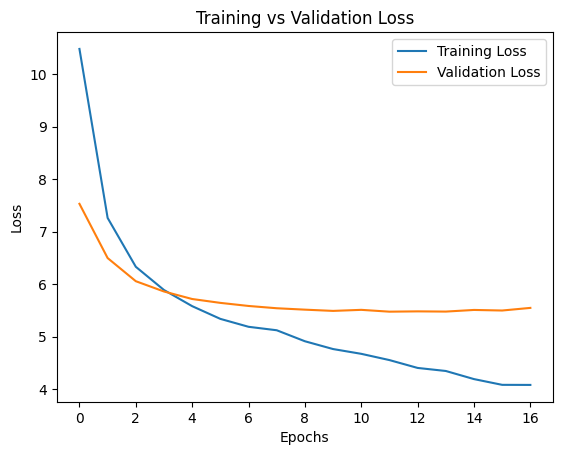

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [29]:
# Save the trained model weights
torch.save(model.state_dict(), "ssd_mobilenet_trained.pth")

In [31]:
# Check if the directory exists, and create it if it doesn't
!mkdir -p /content/Face-Mask-Detection/models

# Move the file
!mv ssd_mobilenet_trained.pth /content/Face-Mask-Detection/models/